In [1]:
import tensorflow as tf
import numpy as np
import os,pathlib

In [2]:
#方法定义 

def preprocess_data(dataset):
    all_images = []
    all_labels = []
    for image,label in dataset:
        preprocessed_image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
        all_images.append(preprocessed_image)
        all_labels.append(label)
    return np.concatenate(all_images),np.concatenate(all_labels)

def get_r_list():
    index_r_list = []
    name_r_list = []
    for i,layer in enumerate(base_model.layers):
        if layer.name[0:5] == 'mixed' or layer.name[-4:] == '5_ac':
            index_r_list.append(i)
            name_r_list.append(layer.name)
    r_list = [0]
    for i in index_r_list:
        r = i/len(base_model.layers)
        r_list.append(r)
    return r_list

def build_model():
    x = conv_base.output
    predictions = classifier(x)
    model = tf.keras.Model(inputs=conv_base.input,outputs=predictions)
    return model

def r_compiled_model():
    model = build_model()
    for layer in model.layers[:int(r*len(conv_base.layers))+1]:
        layer.trainable = False
    for layer in model.layers[int(r*len(conv_base.layers))+1:]:
        layer.trainable = True
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [3]:
#加载数据、预处理数据

base_dir = pathlib.Path('chest_xray2/label')
train_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'train',
                                                            image_size=(224,224),
                                                            batch_size=32)
validation_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'val',
                                                                 image_size=(224,224),
                                                                 batch_size=32)
train_images,train_labels = preprocess_data(train_dataset)
val_images,val_labels = preprocess_data(validation_dataset)

Found 100 files belonging to 2 classes.
Found 160 files belonging to 2 classes.


In [4]:
#分类器初训练

base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet',include_top=False)

inputs = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
x = tf.keras.layers.Dense(units=256,activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1,activation='sigmoid')(x)
classifier_model = tf.keras.Model(inputs=inputs,outputs=outputs)

x = base_model.output
predictions = classifier_model(x)
model = tf.keras.Model(inputs=base_model.input,outputs=predictions)

for layer in model.layers[:len(base_model.layers)]:
    layer.trainable = False
    
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
callback_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath='inceptionresnetv2_r_1.00.keras',
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
history = model.fit(train_images,train_labels,
                    epochs=15,
                    validation_data=(val_images,val_labels),
                    callbacks=callback_list)
r_1_acc = max(history.history['val_accuracy'])
print(r_1_acc)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 5.2208 - accuracy: 0.4800WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001D6AA3EF7B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [5]:
#搜索最佳迁移率R(验证理论)

classifier_p = model.get_layer(model.layers[-1].name)
r_list = get_r_list()
best_acc = r_1_acc
r_acc = []

for i in range(len(r_list)):
    r = r_list[i]
    conv_base = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet',include_top=False)
    classifier = classifier_p
    model = r_compiled_model()
    filepath = 'inceptionresnetv2_r_{:.2f}.keras'.format(r)
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
    history = model.fit(train_images,train_labels,
                        epochs=15,
                        validation_data=(val_images,val_labels),
                        callbacks=callbacks)
    r_acc.append(max(history.history['val_accuracy']))
    
    if i == 0 and r_acc[0] < r_1_acc:
        r_list = r_list[:1]+r_list[:0:-1]
        continue
    if r_acc[i] > best_acc:
        best_acc = r_acc[i]

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.5200 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001D6B53CA9D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 39s 9s/step - loss: 0.5457 - accuracy: 0.6900 - val_loss: 0.4739 - val_accuracy: 0.7937
Epoch 2/15
4/4 [==============================] - 28s 8s/step - loss: 0.5430 - accuracy: 0.6900 - val_loss: 0.4740 - val_accuracy: 0.7937
Epoch 3/15
4/4 [==============================] - 26s 7s/step - loss: 0.5294 - accuracy: 0.7100 - val_loss: 0.4751 - val_accuracy: 0.7937
Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.6300 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001D6E36C5598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach t

In [6]:
#观察结果

print(r_list)
print(r_acc)

[0, 0.8935897435897436, 0.791025641025641, 0.658974358974359, 0.45384615384615384, 0.35128205128205126, 0.19230769230769232, 0.05128205128205128]
[0.8374999761581421, 0.824999988079071, 0.8125, 0.793749988079071, 0.793749988079071, 0.78125, 0.768750011920929, 0.7562500238418579]


In [7]:
##整理结果

r_list.pop(0)
r_0_acc = r_acc.pop(0)

r_list.append(0)
r_acc.append(r_0_acc)

r_list.insert(0,1)
r_acc.insert(0,r_1_acc)
print(r_list)
print(r_acc)

[1, 0.8935897435897436, 0.791025641025641, 0.658974358974359, 0.45384615384615384, 0.35128205128205126, 0.19230769230769232, 0.05128205128205128, 0]
[0.862500011920929, 0.824999988079071, 0.8125, 0.793749988079071, 0.793749988079071, 0.78125, 0.768750011920929, 0.7562500238418579, 0.8374999761581421]


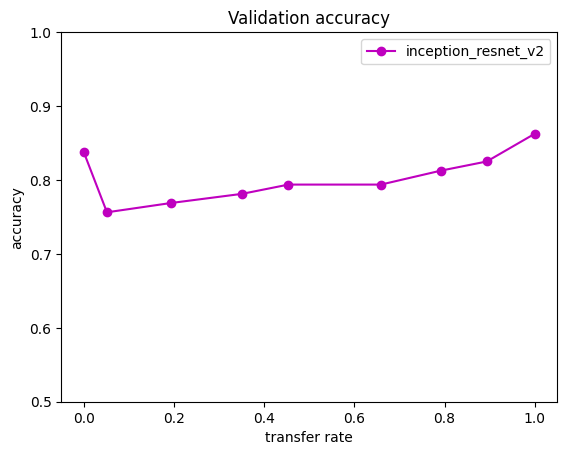

In [8]:
#展示结果

import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='m',label='inception_resnet_v2')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.5,1))

plt.title('Validation accuracy')
plt.legend()
plt.show()


In [3]:
#在unlabel(test)数据集上测试

base_dir = pathlib.Path('chest_xray2')
test_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'unlabel',
                                                            image_size=(224,224),
                                                            batch_size=32)
test_images,test_labels = preprocess_data(test_dataset)

Found 1000 files belonging to 2 classes.


In [4]:
model_0 = tf.keras.models.load_model('inceptionresnetv2_r_0.00.keras')
model_1 = tf.keras.models.load_model('inceptionresnetv2_r_0.05.keras')
model_2 = tf.keras.models.load_model('inceptionresnetv2_r_0.19.keras')
model_3 = tf.keras.models.load_model('inceptionresnetv2_r_0.35.keras')
model_4 = tf.keras.models.load_model('inceptionresnetv2_r_0.45.keras')
model_5 = tf.keras.models.load_model('inceptionresnetv2_r_0.66.keras')
model_6 = tf.keras.models.load_model('inceptionresnetv2_r_0.79.keras')
model_7 = tf.keras.models.load_model('inceptionresnetv2_r_0.89.keras')
model_8 = tf.keras.models.load_model('inceptionresnetv2_r_1.00.keras')

In [5]:
r_acc_t = []
test_loss,test_acc = model_0.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 140s 4s/step - loss: 0.4907 - accuracy: 0.7800
0.7799999713897705


In [6]:
test_loss,test_acc = model_1.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 133s 4s/step - loss: 0.7967 - accuracy: 0.7370
0.7369999885559082


In [7]:
test_loss,test_acc = model_2.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 136s 4s/step - loss: 0.7441 - accuracy: 0.7470
0.746999979019165


In [8]:
test_loss,test_acc = model_3.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 120s 4s/step - loss: 0.7043 - accuracy: 0.7550
0.7549999952316284


In [9]:
test_loss,test_acc = model_4.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 119s 4s/step - loss: 0.6729 - accuracy: 0.7580
0.7580000162124634


In [10]:
test_loss,test_acc = model_5.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 124s 4s/step - loss: 0.5955 - accuracy: 0.7620
0.7620000243186951


In [11]:
test_loss,test_acc = model_6.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 109s 3s/step - loss: 0.5502 - accuracy: 0.7690
0.7689999938011169


In [12]:
test_loss,test_acc = model_7.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 101s 3s/step - loss: 0.5147 - accuracy: 0.7760
0.7760000228881836


In [19]:
test_loss,test_acc = model_8.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

32/32 [==============================] - 84s 3s/step - loss: 0.5629 - accuracy: 0.7620
0.7620000243186951


In [15]:
r_acc_t = r_acc_t[::-1]
print(r_acc_t)

[0.7620000243186951, 0.7760000228881836, 0.7689999938011169, 0.7620000243186951, 0.7580000162124634, 0.7549999952316284, 0.746999979019165, 0.7369999885559082, 0.7799999713897705]


In [17]:
r_list = [1, 0.8935897435897436, 0.791025641025641, 0.658974358974359, 0.45384615384615384, 0.35128205128205126, 0.19230769230769232, 0.05128205128205128, 0]
r_acc = [0.862500011920929, 0.824999988079071, 0.8125, 0.793749988079071, 0.793749988079071, 0.78125, 0.768750011920929, 0.7562500238418579, 0.8374999761581421]

<Figure size 640x480 with 0 Axes>

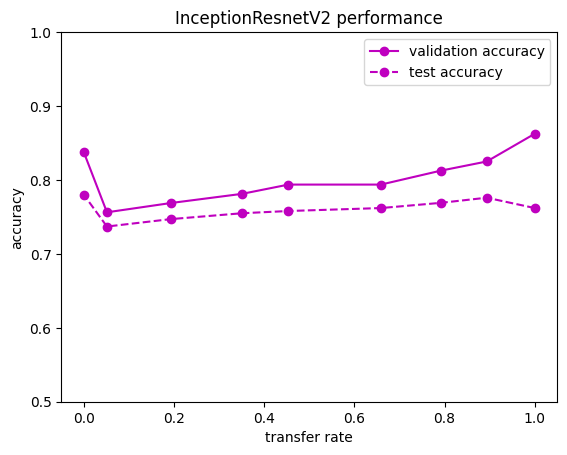

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='m',label='validation accuracy')
plt.plot(r_list,r_acc_t,linestyle='--',marker='o',color='m',label='test accuracy')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.5,1))

plt.title('InceptionResnetV2 performance')
plt.legend()
plt.show()


In [20]:
#在unlabel(test)数据集上测试聚类
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [21]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_0.get_layer('conv_7b_ac').output)
encoder_0 = tf.keras.Model(inputs=model_0.input,outputs=feature)
X = encoder_0.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [22]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.6


In [23]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_1.get_layer('conv_7b_ac').output)
encoder_1 = tf.keras.Model(inputs=model_1.input,outputs=feature)
X = encoder_1.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [25]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.617


In [26]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_2.get_layer('conv_7b_ac').output)
encoder_2 = tf.keras.Model(inputs=model_2.input,outputs=feature)
X = encoder_2.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [28]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.614


In [29]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_3.get_layer('conv_7b_ac').output)
encoder_3 = tf.keras.Model(inputs=model_3.input,outputs=feature)
X = encoder_3.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [32]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.614


In [33]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_4.get_layer('conv_7b_ac').output)
encoder_4 = tf.keras.Model(inputs=model_4.input,outputs=feature)
X = encoder_4.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [34]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.616


In [35]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_5.get_layer('conv_7b_ac').output)
encoder_5 = tf.keras.Model(inputs=model_5.input,outputs=feature)
X = encoder_5.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [37]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.61


In [38]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_6.get_layer('conv_7b_ac').output)
encoder_6 = tf.keras.Model(inputs=model_6.input,outputs=feature)
X = encoder_6.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [40]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.634


In [41]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_7.get_layer('conv_7b_ac').output)
encoder_7 = tf.keras.Model(inputs=model_7.input,outputs=feature)
X = encoder_7.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [42]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.635


In [43]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_8.get_layer('conv_7b_ac').output)
encoder_8 = tf.keras.Model(inputs=model_8.input,outputs=feature)
X = encoder_8.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [44]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.635


In [45]:
r_acc_k = [0.635,0.635,0.634,0.61,0.616,0.614,0.614,0.617,0.6]

In [50]:
r_acc_t.pop()
print(r_acc_t)

[0.7620000243186951, 0.7760000228881836, 0.7689999938011169, 0.7620000243186951, 0.7580000162124634, 0.7549999952316284, 0.746999979019165, 0.7369999885559082, 0.7799999713897705]


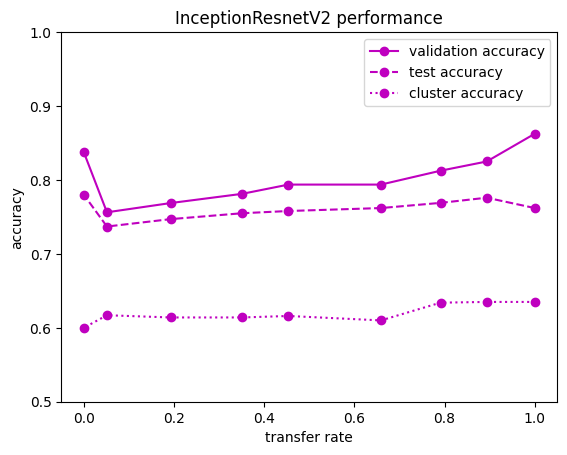

In [52]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='m',label='validation accuracy')
plt.plot(r_list,r_acc_t,linestyle='--',marker='o',color='m',label='test accuracy')
plt.plot(r_list,r_acc_k,linestyle=':',marker='o',color='m',label='cluster accuracy')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.5,1))

plt.title('InceptionResnetV2 performance')
plt.legend()
plt.show()